In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [15]:
def extract_experiments(experiment_states):
    for exp_state in experiment_states:
        # if exp_state.rev == 'workspace':
        #     continue
            
        experiments = exp_state.experiments or []

        for experiment in experiments:
            revs = experiment.revs or []
            for rev in revs:
                params = next(iter(rev.data.params.values()), {}).get("data")
                metrics = next(iter(rev.data.metrics.values()), {}).get("data")
                yield {
                    'commit': exp_state.rev,
                    'id': rev.rev,
                    'name': rev.name,
                    'params': params,
                    'metrics': metrics,
                }

In [16]:
from dvc.repo import Repo

# Initialize a DVC Repo object
repo = Repo()

# Get the experiments
experiments = list(extract_experiments(repo.experiments.show(n=20)))
len(experiments)

0

In [8]:
df = (
    pd.json_normalize(experiments)
    .sort_values(["params.qa.model", "params.qa.prompt", "params.qa.temperature", "params.run"])
    .drop(columns=["commit", "id", "name"])
)
dataset_path = "bdsaglam/musique"
mask = df["params.dataset.path"] == dataset_path
df = df.loc[mask]
df

KeyError: 'params.qa.model'

In [5]:
metric_cols = [col for col in df.columns if col.startswith("metrics.")]

In [6]:
df.drop(columns=['params.dataset.path', 'params.dataset.name', 'params.dataset.split', 'params.qa.model']).groupby(["params.qa.prompt", "params.qa.temperature"]).aggregate(['mean', 'max']).loc[:, metric_cols]

metrics.exact_match            \
                                                      mean       max   
params.qa.prompt params.qa.temperature                                 
cot-fs           0.1                              0.500000  0.500000   
                 0.5                              0.500000  0.500000   
                 0.7                              0.500000  0.500000   
                 1.0                              0.500000  0.500000   
cot-zs           0.1                              0.500000  0.500000   
                 0.5                              0.500000  0.500000   
                 0.7                              0.500000  0.500000   
                 1.0                              0.500000  0.500000   
cte              0.1                              0.500000  0.500000   
                 0.5                              0.500000  0.500000   
                 0.7                              0.500000  0.500000   
                 1.0                              0.500000  0.500000   
standard         0.1                              0.543546  0.544063   
                 0.5                              0.536616  0.541167   
                 0.7                              0.536202  0.536202   
                 1.0                              0.500000  0.500000   

                                       metrics.f1            \
                                             mean       max   
params.qa.prompt params.qa.temperature                        
cot-fs           0.1                     0.660000  0.660000   
                 0.5                     0.660000  0.660000   
                 0.7                     0.660000  0.660000   
                 1.0                     0.660000  0.660000   
cot-zs           0.1                     0.660000  0.660000   
                 0.5                     0.660000  0.660000   
                 0.7                     0.660000  0.660000   
                 1.0                     0.660000  0.660000   
cte              0.1                     0.660000  0.660000   
                 0.5                     0.660000  0.660000   
                 0.7                     0.660000  0.660000   
                 1.0                     0.660000  0.660000   
standard         0.1                     0.651899  0.652452   
                 0.5                     0.648792  0.650146   
                 0.7                     0.647437  0.647437   
                 1.0                     0.660000  0.660000   

                                       metrics.fuzzy_match            
                                                      mean       max  
params.qa.prompt params.qa.temperature                                
cot-fs           0.1                              0.700000  0.700000  
                 0.5                              0.700000  0.700000  
                 0.7                              0.700000  0.700000  
                 1.0                              0.700000  0.700000  
cot-zs           0.1                              0.700000  0.700000  
                 0.5                              0.700000  0.700000  
                 0.7                              0.700000  0.700000  
                 1.0                              0.700000  0.700000  
cte              0.1                              0.700000  0.700000  
                 0.5                              0.700000  0.700000  
                 0.7                              0.700000  0.700000  
                 1.0                              0.700000  0.700000  
standard         0.1                              0.607778  0.609847  
                 0.5                              0.603227  0.604468  
                 0.7                              0.598676  0.598676  
                 1.0                              0.700000  0.700000

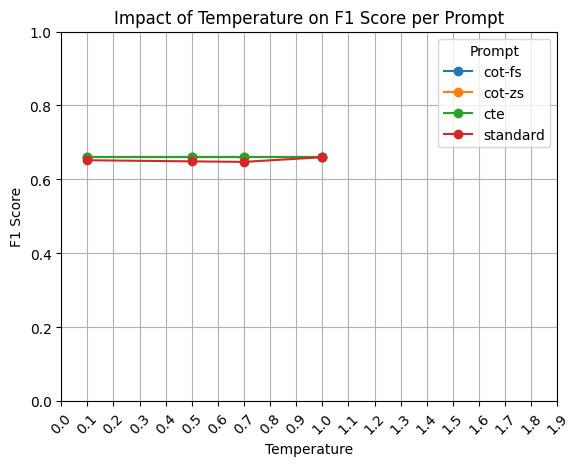

In [11]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.prompt", "params.qa.temperature"])[
        ["metrics.exact_match", "metrics.f1", "metrics.fuzzy_match"]
    ]
    .mean()
    .reset_index()
)

# Plotting the impact of temperature per prompt
prompts = df_avg["params.qa.prompt"].unique()

for prompt in prompts:
    subset = df_avg[df_avg["params.qa.prompt"] == prompt]
    plt.plot(subset["params.qa.temperature"], subset["metrics.f1"], marker="o", label=prompt)

plt.ylim(0, 1)
plt.xlabel("Temperature")
plt.ylabel("F1 Score")
plt.title("Impact of Temperature on F1 Score per Prompt")
plt.legend(title="Prompt")
plt.xticks(ticks=list(np.arange(0, 2, 0.1)), rotation=45)  # Adding xticks for temperature values in range(0, 2, 0.1)
plt.grid(True)
plt.show()

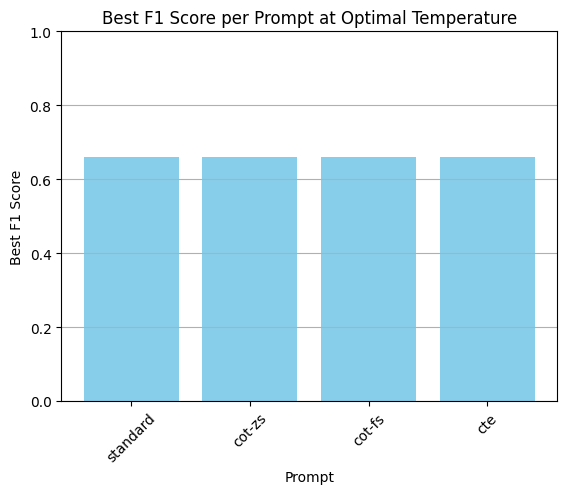

In [8]:
# To compare the prompts at the best temperature
# Assuming "best temperature" is defined as the one with the highest average F1 score
df_best_temp = (
    df_avg.loc[df_avg.groupby("params.qa.prompt")["metrics.f1"].idxmax()]
    .set_index("params.qa.prompt", drop=False)
    .loc[["standard", "cot-zs", "cot-fs", "cte"]]
    .copy()
)

# Plotting the best F1 scores per prompt
plt.bar(df_best_temp["params.qa.prompt"], df_best_temp["metrics.f1"], color="skyblue")
plt.ylim(0, 1)
plt.xlabel("Prompt")
plt.ylabel("Best F1 Score")
plt.title("Best F1 Score per Prompt at Optimal Temperature")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

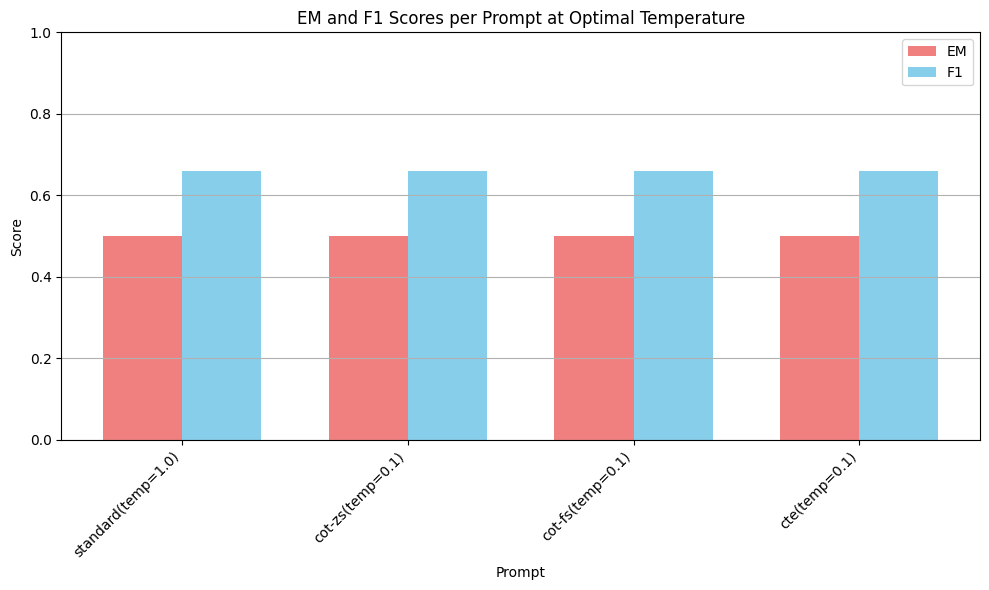

In [9]:
# Plotting EM and F1 scores together per prompt with temperature annotations
plt.figure(figsize=(10, 6))

# Create x-tick labels that include both the prompt and temperature
xs = [
    f"{prompt}(temp={temperature})"
    for prompt, temperature in zip(
        df_best_temp["params.qa.prompt"].values, df_best_temp["params.qa.temperature"].values
    )
]

# Set the width for the bars and the positions
bar_width = 0.35
index = np.arange(len(xs))

# Plot Exact Match (EM) bars
bar1 = plt.bar(index, df_best_temp["metrics.exact_match"], bar_width, label="EM", color="lightcoral")

# Plot F1 bars, shifted by bar_width for side-by-side bars
bar2 = plt.bar(index + bar_width, df_best_temp["metrics.f1"], bar_width, label="F1", color="skyblue")

# Add labels and titles
plt.xlabel('Prompt')
plt.ylabel('Score')
plt.title('EM and F1 Scores per Prompt at Optimal Temperature')

# Set x-ticks with prompt and temperature labels
plt.xticks(index + bar_width / 2, xs, rotation=45, ha='right')

# Add a legend to differentiate between EM and F1 scores
plt.legend()

# Add a grid and display the plot
plt.grid(axis='y')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


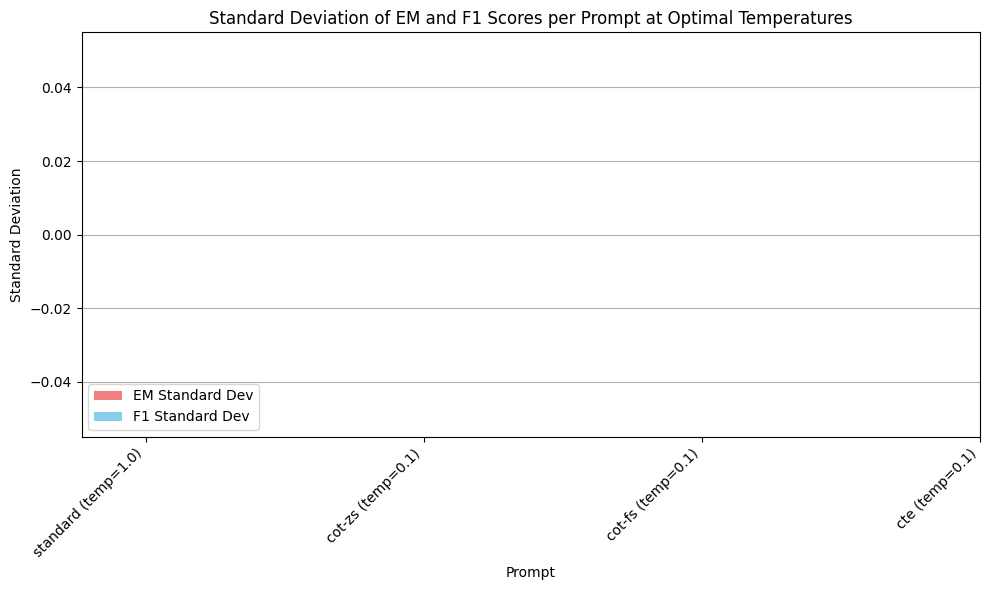

In [10]:
# Initialize an empty list to store stats
stats = []

# Loop through each prompt and its optimal temperature
for index, row in df_best_temp.iterrows():
    prompt = row['params.qa.prompt']
    optimal_temp = row['params.qa.temperature']
    
    # Select rows that correspond to the current prompt and its optimal temperature
    df_temp = df[(df['params.qa.prompt'] == prompt) & (df['params.qa.temperature'] == optimal_temp)]
    
    # Calculate stats for Exact Match and F1 scores
    em_std = df_temp['metrics.exact_match'].std()
    f1_std = df_temp['metrics.f1'].std()
    
    # Append to the list
    stats.append({
        'prompt': prompt,
        'optimal_temp': optimal_temp,
        'EM.std': em_std,
        'F1.std': f1_std
    })

# Convert the stats to a DataFrame
df_stats = pd.DataFrame(stats).set_index('prompt', drop=False).loc[['standard', 'cot-zs', 'cot-fs', 'cte']].copy()

# Combine prompt and optimal temperature for xticks
df_stats['prompt_with_temp'] = df_stats['prompt'] + " (temp=" + df_stats['optimal_temp'].astype(str) + ")"

# Plotting the stats of EM and F1 scores for each prompt
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for EM stats
bar_width = 0.35
index = np.arange(len(df_stats))

bar1 = ax.bar(index, df_stats['EM.std'], bar_width, label='EM Standard Dev', color='lightcoral')

# Bar plot for F1 stats, offset by bar_width for side-by-side bars
bar2 = ax.bar(index + bar_width, df_stats['F1.std'], bar_width, label='F1 Standard Dev', color='skyblue')

# Add labels and titles
ax.set_xlabel('Prompt')
ax.set_ylabel('Standard Deviation')
ax.set_title('Standard Deviation of EM and F1 Scores per Prompt at Optimal Temperatures')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_stats['prompt_with_temp'], rotation=45, ha='right')
ax.legend()

# Add a grid and display the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()
